PyTorch Geometric'te veri işleme, veri kümeleri, yükleyici ve dönüşümler hakkında bilgi edindikten sonra, ilk grafik sinir ağımızı uygulamanın zamanı geldi!

Önce bir MLP ağı oluşturacağız. Daha sonra ise basit bir GCN ağı kullanacağız ve deneyleri, daha önce de gördüğümüz Cora atıf veri setinde gerçekleştireceğiz. 

Önce Cora veri setini yüklememiz gerekiyor:

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

#Cora veri seti, yedi sınıftan birinde sınıflandırılan 2708 bilimsel yayından oluşur.
#Alıntı ağı 5429 bağlantıdan oluşmaktadır. Veri setindeki her yayın, sözlükte karşılık 
#gelen kelimenin yokluğunu/mevcudiyetini gösteren 0/1-değerli bir kelime vektörü ile tanımlanır. 
#Sözlük 1433 farklı kelimeden oluşmaktadır.

print('Çizge sayısı:', len(dataset))
print('Nokta sınıf sayısı:' , dataset.num_classes)
print('Nokta özellik sayısı:', dataset.num_node_features)


Çizge sayısı: 1
Nokta sınıf sayısı: 7
Nokta özellik sayısı: 1433


In [2]:
import torch
import networkx as nx
    
data = dataset[0]

print()
print(data)
print('===========================================================================================================')

print(f'Nokta sayısı: {data.num_nodes}')
print(f'Kenar sayısı: {data.num_edges}')
print(f'Ortalama kenar sayısı: {data.num_edges / data.num_nodes:.2f}')
print(f'Eğitim için kullanılacak nokta sayısı: {data.train_mask.sum()}')
print(f'Eğitim nokta oranı: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Ayrık noktalar var mı: {data.contains_isolated_nodes()}')
print(f'Döngüler var mı: {data.contains_self_loops()}')
print(f'Yönsüz mü: {data.is_undirected()}')



Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Nokta sayısı: 2708
Kenar sayısı: 10556
Ortalama kenar sayısı: 3.90
Eğitim için kullanılacak nokta sayısı: 140
Eğitim nokta oranı: 0.05
Ayrık noktalar var mı: False
Döngüler var mı: False
Yönsüz mü: True


/Users/kamer/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/Users/kamer/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Önce basit bir MLP modeli kuralım. Gerçek hayatta da bir makalenin, raporun vs. içeriğinden, kelimelerinden bu makalenin tipini anlayabiliriz. Bu yöntemde çizge verisi (örneğin noktalar arası bağlantılar) değil, sadece nokta özellikleri kullanılacaktır. 

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Şimdi bu modeli eğitelim ve test edelim

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['OMP_NUM_THREADS']='1' 

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Türevleri temizleyelim.
    out = model(data.x)  # Bir adım ileri 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Hata fonksiyonunu hesaplayalım.
    loss.backward()  # Türevleri hesaplayalım.
    optimizer.step()  # Parametreleri güncelleyelim.
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Olasılığı en yüksek sınıfı kullanalım
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Sonuçları gerçek sonuçlarla kontrol edelim
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Doğruluğu hesaplayalım
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


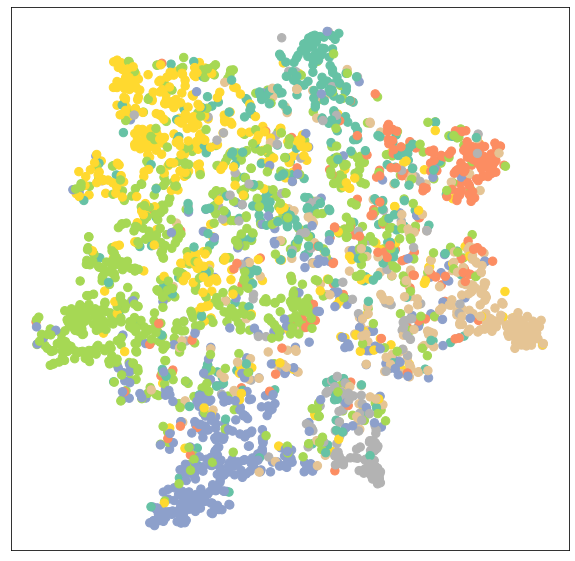

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    #T-distributed stochastic neighbor embedding
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
model.eval()

out = model(data.x)
visualize(out, color=data.y)

Şimdi de iki katmanlı bir GCN yapısı oluşturalım. Aşağıdaki **constructor**, ağımızın ileri besleme aşamasında çağrılan iki GCNConv katmanını tanımlar. 

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        #Dogrusal olmayan fonksiyonların katmanlara entegre 
        #edilmediğine ve bu nedenle daha sonra uygulanması 
        #gerektiğine dikkat edin. 
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        #Ara katmanda ReLU'yu kullanmayı seçtik  
        x = x.relu()
        x = F.dropout(x, training = self.training)  #dropout 
        x = self.conv2(x, edge_index)
        #Son olarak sınıf sayısı üzerinden bir softmax dağılımı elde ediyoruz.
        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Türevleri temizle.
    out = model(data.x, data.edge_index)  # Bir ileri adım atalım.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Hatayı hesapla. 
    loss.backward()  # Türevleri derive et.
    optimizer.step()  # Parametreleri güncelle
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # .
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return test_acc


for epoch in range(1, 100):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9412
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9308
Epoch: 005, Loss: 1.9216
Epoch: 006, Loss: 1.9137
Epoch: 007, Loss: 1.9078
Epoch: 008, Loss: 1.8986
Epoch: 009, Loss: 1.8868
Epoch: 010, Loss: 1.8825
Epoch: 011, Loss: 1.8701
Epoch: 012, Loss: 1.8614
Epoch: 013, Loss: 1.8486
Epoch: 014, Loss: 1.8323
Epoch: 015, Loss: 1.8344
Epoch: 016, Loss: 1.8186
Epoch: 017, Loss: 1.8031
Epoch: 018, Loss: 1.7980
Epoch: 019, Loss: 1.7813
Epoch: 020, Loss: 1.7766
Epoch: 021, Loss: 1.7478
Epoch: 022, Loss: 1.7385
Epoch: 023, Loss: 1.7304
Epoch: 024, Loss: 1.7120
Epoch: 025, Loss: 1.7010
Epoch: 026, Loss: 1.6917
Epoch: 027, Loss: 1.6672
Epoch: 028, Loss: 1.6382
Epoch: 029, Loss: 1.6474
Epoch: 030, Loss: 1.6297
Epoch: 031, Loss: 1.6014
Epoch: 032, Loss: 1.5760
Epoch: 033, Loss: 1.5732
Epoch: 034, Loss: 1.5705
Epoch: 035, Loss: 1.5443
Epoch: 036, Loss: 1.5131
Epoch: 037, Loss: 1.4721
Epoch: 038, Loss: 1.4774
Epoch: 039, Loss: 1.4380
Epoch: 040, Loss: 1.4553


In [9]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8100


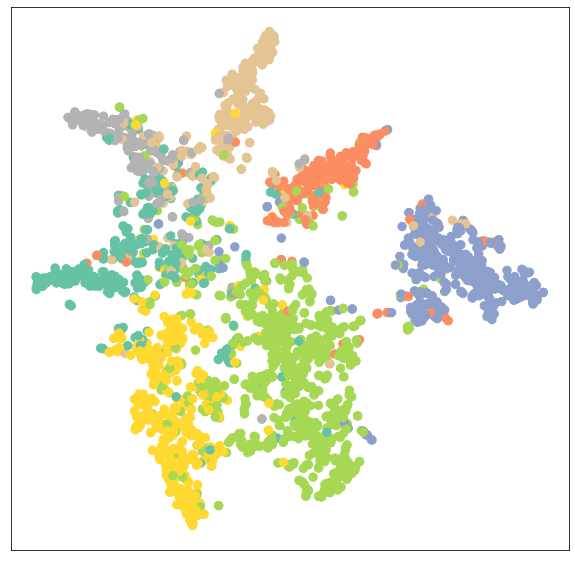

In [10]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)